In [339]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [318]:
#list the variables:
times = [0,30,120,240,360,14400]
doses = [20,100]
receptors = ["A549-1","A549-2","A549-3"]


#data:
data_20 = np.array([127.17,117.28,114.59,
128.55,130.2,132.86,
142.35,113.91,138.02,
172.8,121.29,133.6,
131.85,114.38,114.73,
144.83,122.45,137.77])

data_100 = np.array([127.17,117.28,114.59,
129.05,134.61,131.62,
140.2,130.94,132.76,
153.64,140.6,137.46,
143.54,115.82,122.97,
157.85,125.28,145.03])

In [319]:
#construct tables and inspect the mean

df_20 = pd.DataFrame(index=times,columns=receptors, data=data_20.reshape(6,3))
df_20["mean"]=df_20.mean(axis=1)

df_100 = pd.DataFrame(index=times,columns=receptors, data=data_100.reshape(6,3))
df_100["mean"]=df_100.mean(axis=1)

In [320]:
df_20.head(3)

,A549-1,A549-2,A549-3,mean
0,127.17,117.28,114.59,119.680000
30,128.55,130.20,132.86,130.536667
120,142.35,113.91,138.02,131.426667


In [321]:
df_100.head(3)

,A549-1,A549-2,A549-3,mean
0,127.17,117.28,114.59,119.680000
30,129.05,134.61,131.62,131.760000
120,140.20,130.94,132.76,134.633333


In [322]:
mean_intensity = np.concatenate((np.array(df_20["mean"]),np.array(df_100["mean"])))

In [333]:
df_mean = pd.DataFrame({"time":times, "dose_20": df_20["mean"], "dose_100": df_100["mean"]}).set_index("time")


In [335]:
#mean intensity for each time step at given dose:

df_mean

,dose_20,dose_100
time,,
0,119.680000,119.680000
30,130.536667,131.760000
120,131.426667,134.633333
240,142.563333,143.900000
360,120.320000,127.443333
14400,135.016667,142.720000


In [325]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [348]:
#some array operations to format data 

dose=np.repeat(["20", "100"], 18)
time=np.tile(np.repeat(times, 3), 2)
data=np.concatenate((data_20,data_100))

In [349]:
#inspect formatted data

df = pd.DataFrame({'dose': dose,
                   'time': time,
                   'intensity': data})

df.head(5)

,dose,time,intensity
0,20,0,127.17
1,20,0,117.28
2,20,0,114.59
3,20,30,128.55
4,20,30,130.20


In [350]:
#define our model and test stat: 2-way ANOVA (f-testing)

model = ols('intensity ~ C(dose) + C(time) + C(dose):C(time)', data=df).fit()
df_stat = sm.stats.anova_lm(model, typ=2)
df_stat

,sum_sq,df,F,PR(>F)
C(dose),106.021344,1.0,0.682811,0.416760
C(time),2352.136267,5.0,3.029701,0.029339
C(dose):C(time),79.452389,5.0,0.102340,0.990698
Residual,3726.524600,24.0,NaN,NaN


In [342]:
#P-values for all degrees of freedom and interation

variables=["dose", "time", "dose*time"]

for i,j in zip(range(0,3), vars):
    print(f"p-val ({j})={np.round(df_stat['PR(>F)'][i],3)}")

p-val (dose)=0.417
p-val (time)=0.029
p-val (dose*time)=0.991


In [356]:
import statistics
import scipy.stats as stats

In [352]:
mean = df["intensity"].mean()
std = statistics.stdev(df["intensity"])

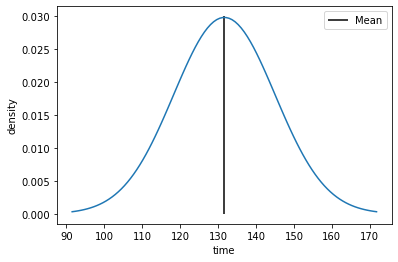

In [376]:
plt.figure()
x = np.linspace(mean - 3*std, mean + 3*std, 100)
plt.vlines(mean,0,0.03,label="Mean")
plt.plot(x, stats.norm.pdf(x, mean, std))
plt.xlabel("time")
plt.ylabel("density")
plt.legend()
plt.show()

In [386]:
#perform multiwise comparisons:

from statsmodels.stats.multicomp import pairwise_tukeyhsd

m_comp_dose = pairwise_tukeyhsd(endog=df["intensity"], groups=df['dose'], alpha=0.05)
m_comp_time = pairwise_tukeyhsd(endog=df["intensity"], groups=df['time'], alpha=0.05)



In [387]:
print(m_comp_dose)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   100     20  -3.4322 0.4495 -12.549 5.6845  False
---------------------------------------------------


As already expected the null hypothesis is not rejected when considering only the dose.

In [388]:
print(m_comp_time)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0     30  11.4683 0.5155   -8.584 31.5207  False
     0    120    13.35 0.3531  -6.7024 33.4024  False
     0    240  23.5517  0.014   3.4993  43.604   True
     0    360   4.2017    0.9 -15.8507  24.254  False
     0  14400  19.1883 0.0671   -0.864 39.2407  False
    30    120   1.8817    0.9 -18.1707  21.934  False
    30    240  12.0833 0.4625   -7.969 32.1357  False
    30    360  -7.2667 0.8663  -27.319 12.7857  False
    30  14400     7.72 0.8284 -12.3324 27.7724  False
   120    240  10.2017 0.6212  -9.8507  30.254  False
   120    360  -9.1483 0.7092 -29.2007  10.904  False
   120  14400   5.8383    0.9  -14.214 25.8907  False
   240    360   -19.35 0.0636 -39.4024  0.7024  False
   240  14400  -4.3633    0.9 -24.4157  15.689  False
   360  14400  14.9867 0.2363  -5.0657  35.039  False
----------------------------

This result suggests a signficent change in the mean occurs between 0 and 240 minutes.
I would suggest more granular time intervals for a more accurate time measurement.